# Time Series Forecast On ParagonCorps Item Sales
This time series prediction project focused on forecasting the sales of various items for a company from the beginning of 2022 until April 2023. The project involved analyzing the dataset, identifying trends and patterns, and testing various models such as ARIMA, SARIMA, Exponential Smoothing, ANN and FB Prophet models to determine the best one for deployment

# Introduction
My name is Andrian Tanjung, I was from non-IT background that choosed to switch my career into Data Science by studying in Hacktiv8. Entry-level Data Scientist with experience in providing leadership and planning for future decisions. Excited to do this time series project, it will be my first time series project to be done so I will write this project in third point of view. The objective of this project is to determine which model can provide the best accuracy score of the forecast. Link for my github: https://github.com/andreetanjung


# External Link
https://public.tableau.com/app/profile/andrian5182/viz/ForecastingDashboard_16816171182120/Dashboard1?publish=yes
The external link provided is a tableu dashboard about interactive forecasting towards the ParagonCorp Item Sales

# Working Area

### Import Libraries

In [1]:
## Basic library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dtm
import pylab
import pmdarima as pm

## EDA and visualization
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from colorama import Fore

## Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet

## Preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam

## Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Warning
import warnings 
warnings.filterwarnings(action='ignore')

c:\Users\Andrian\anaconda3\envs\tf2.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Data Loading And Overview

In [2]:
df = pd.read_csv('sample_dataset_timeseries_noarea.csv') ## read the csv file
df.head()                                                ## dataset overview

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [3]:
df.info() ## information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


The dataset consists of 102,733 data entries with 4 object data types and 1 integer data type. Three of the object data types need to be converted into datetime data types. And we can see that there are some missing data, let us check it out more about it.

In [4]:
df.isnull().sum() ## checking the missing values from the dataframe

week_number        0
week_start_date    0
week_end_date      0
product_item       2
quantity           0
dtype: int64

It seems like we have 2 missing value on the product_item column. Let us take a closer look what the missing value is about.

In [5]:
df[df.isnull().any(axis=1)] ## caling the missing value from the dataset

,week_number,week_start_date,week_end_date,product_item,quantity
18048,2022-12,2022-03-21,2022-03-27,NaN,119
19536,2022-13,2022-03-28,2022-04-03,NaN,147


The missing values occurred in only two consecutive rows and there is no apparent pattern or relationship with any other variables in the dataset. Therefore, we can conclude that the missing values are missing completely at random (MCAR). Additionally, since the missing values represent such a small proportion of the overall dataset (less than 0.1%), we can simply drop these rows without impacting the integrity of our analysis.

In [6]:
df.duplicated().sum() ## check if there is duplicated rows

0

There is no duplicated rows on this dataset.

In [7]:
df.describe() ## view statistical summary of the numerical columns

,quantity
count,102733.000000
mean,3191.562419
std,12074.631014
min,0.000000
25%,75.000000
50%,414.000000
75%,1890.000000
max,774732.000000


From the result above we can conclude that:
- There is a significant difference between the mean and median values in the 'quantity' column, which indicates that the distribution is skewed and there are many outliers needs to be handled later.
- Minimum quantity sold is 0 may indicate the presence of missing data or a lack of sales during certain periods.

In [8]:
df[(df['quantity']==0)]

,week_number,week_start_date,week_end_date,product_item,quantity
72589,2022-47,2022-11-21,2022-11-27,6adc4ddabd44c5aa2f4c6105ceda926a,0
74199,2022-48,2022-11-28,2022-12-04,6adc4ddabd44c5aa2f4c6105ceda926a,0
75806,2022-49,2022-12-05,2022-12-11,6adc4ddabd44c5aa2f4c6105ceda926a,0


In [9]:
df[(df['product_item']=='6adc4ddabd44c5aa2f4c6105ceda926a')]

,week_number,week_start_date,week_end_date,product_item,quantity
207,2021-52,2021-12-27,2022-01-02,6adc4ddabd44c5aa2f4c6105ceda926a,286
1095,2022-01,2022-01-03,2022-01-09,6adc4ddabd44c5aa2f4c6105ceda926a,8881
2589,2022-02,2022-01-10,2022-01-16,6adc4ddabd44c5aa2f4c6105ceda926a,21732
4061,2022-03,2022-01-17,2022-01-23,6adc4ddabd44c5aa2f4c6105ceda926a,12633
5539,2022-04,2022-01-24,2022-01-30,6adc4ddabd44c5aa2f4c6105ceda926a,20142
7009,2022-05,2022-01-31,2022-02-06,6adc4ddabd44c5aa2f4c6105ceda926a,11671
8478,2022-06,2022-02-07,2022-02-13,6adc4ddabd44c5aa2f4c6105ceda926a,15671
9953,2022-07,2022-02-14,2022-02-20,6adc4ddabd44c5aa2f4c6105ceda926a,16165
11404,2022-08,2022-02-21,2022-02-27,6adc4ddabd44c5aa2f4c6105ceda926a,26703
12836,2022-09,2022-02-28,2022-03-06,6adc4ddabd44c5aa2f4c6105ceda926a,18601


Based on the data provided, the assumption for missing data on 'quantity' column can be eliminated since there were many instances where the quantity sold was less than 10. It could be because of the products were not in stock or any other reason.

We have an overview of the dataframe of the dataset now and we can move on to data cleaning. Things need to be done on data cleaning:
- handle missing value
- change datetime data type

### Data Cleaning


In [10]:
df.dropna(inplace=True)     ## remove missing value
df.isnull().sum()           ## make sure missing value has been handled     

week_number        0
week_start_date    0
week_end_date      0
product_item       0
quantity           0
dtype: int64

In [11]:
## Convert object to datetime type
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df['week_end_date'] = pd.to_datetime(df['week_end_date'])

### Exploratory Data Analysis

##### -- General Analysis --

In [12]:
df_eda = df.copy()  ## create a copy of dataframe to keep the original one

In [13]:
df_eda.product_item.value_counts() ## seeing how many products in the dataset

0073377087c7ddace313ff829cd7b0b3    67
870b3ad8c41b746b29ba31f6e4040950    67
9264576b8833b892b34a39525bcdd271    67
921cfbd1930eeee6b82a7b053c4ed8dc    67
91f65f29b32c39788b4294cbe2be7024    67
                                    ..
d97d3a3e53124b6b1a8313403f54f6b8     1
d963020bd8d76659c6768ad252be9629     1
d4e90f2dcbcf53757d6bd1f3b6f368cb     1
170ad92bf82a3509886ceb841cd6e3c3     1
ff9d05a4d6f922b3ab1653f58165b8ce     1
Name: product_item, Length: 2309, dtype: int64

There are 2309 unique items sold on the dataset and there are several items that just sold once in 67 weeks. Before taking any measurement towards the items, we need to see the total number of items sold.

In [14]:
df_eda.groupby('product_item')['quantity'].sum().sort_values(ascending=False) ## seeing the most product sold

product_item
2949ca4cfbf13969bccfbb9817f2526a    18206376
2db7ed9bd7573aec037aac59237cb3dd     9122007
160eb16a7369a645ec75caa3f14543d4     6771207
229a936943f7da9feea525f1a48d1d03     6658518
0f9d1e065ad64ecd7237084107a4bfbd     4202082
                                      ...   
3619fde2d22f364f14a595f2c7d95eb0           2
d79c7a64e815ebb411b976fc2444f750           2
3db6960af3e714e64aa08ee193515a62           2
41cdee563778c1530de2b9b4480f6d4e           2
91c30a9df505d481487e1d5099cc57dd           2
Name: quantity, Length: 2309, dtype: int64

In [15]:
df_item_total = df_eda.groupby('product_item')['quantity'].sum().sort_values(ascending=False)
df_item_total_less_than_100 = df_item_total[df_item_total > 1000000]
df_item_total_less_than_100

product_item
2949ca4cfbf13969bccfbb9817f2526a    18206376
2db7ed9bd7573aec037aac59237cb3dd     9122007
160eb16a7369a645ec75caa3f14543d4     6771207
229a936943f7da9feea525f1a48d1d03     6658518
0f9d1e065ad64ecd7237084107a4bfbd     4202082
                                      ...   
476d57fa4c80b70e25dbe10bfde6d30a     1063292
16e31cc95002f938d004e557bcf8850f     1059074
e1fc5fe41ff0218d084666b4953c404e     1052963
9264576b8833b892b34a39525bcdd271     1027083
a5e3487289d2b241ef1ed8555751963c     1011000
Name: quantity, Length: 76, dtype: int64

The dataset revealed that the most sold product item is '2949ca4cfbf13969bccfbb9817f2526a', with sales twice as high as the second-best item. However, there were also several items with sales of less than 100 quantities in a year, making it difficult to take action without further information on the products. Assuming that these low-sold products have higher sales prices but less profitability compared to high-sold items with lower sales prices, it would be better to evaluate if the bottom 5 quantity-sold items, as example, are still needed to be sold in the future. This would enable the company to streamline its inventory and focus on more profitable products

##### -- Decomposition Analysis --

In [16]:
df_comp = pd.DataFrame(df_eda.groupby('week_end_date')['quantity'].sum()) ## making a new variable for total week quantity combined
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2022-01-02 to 2023-04-09
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   quantity  67 non-null     int64
dtypes: int64(1)
memory usage: 1.0 KB


The reason for selecting 'week_end_date' as the index for the total weekly items sold is that it is a common practice to calculate the total items sold at the end of the week, like some companies generate weekly inventory reports. The dataframe spans from 2nd January 2022 until 9th April 2023, covering a total of 67 weeks. Here we use all items combined to see the overal quantity sold in the dataset.

<Axes: title={'center': 'Weekly Item Sold'}, xlabel='week_end_date'>

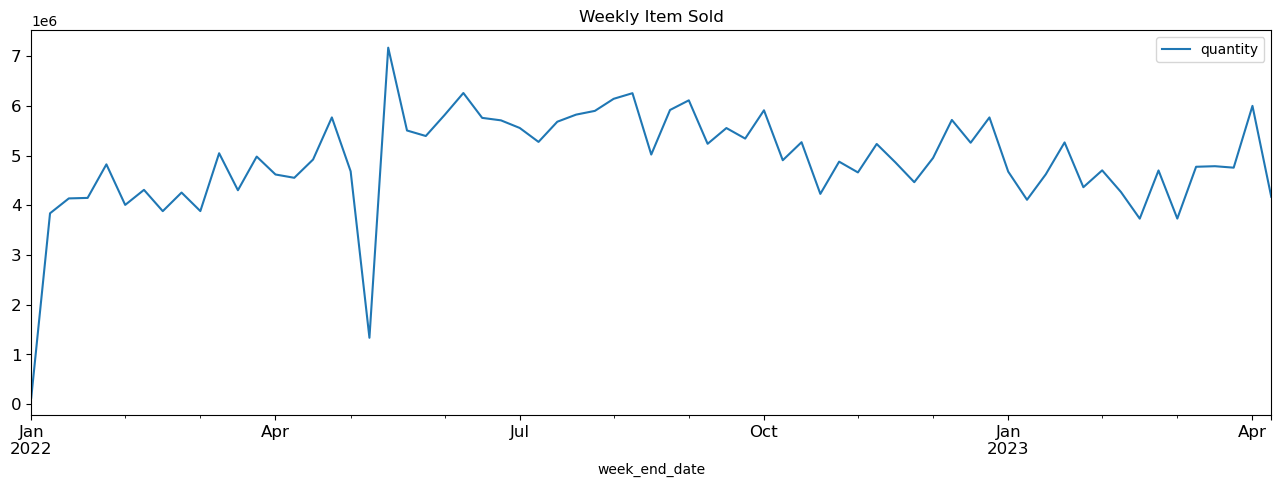

In [17]:
df_comp.plot(figsize=(16,5), title= 'Weekly Item Sold', fontsize=12) ## visualization

Based on the visualization, we can draw the following conclusions:
- In January, the store experienced the least sales, possibly due to the holiday season and the store's recent opening.
- There was a 300% surge in sales after the first week of opening.
- The number of items sold sharply declined in May, but there was a parabolic increase in the following week. This could be caused to a long weekend during that period, and it was the month with the highest sales.
- From May to mid-November, there was a declining trend, which continued from the end of 2022 until March 2023.

*Assumption is taken based on Indonesian 2022 calender, source: https://www.hashmicro.com/id/blog/kalender-2022-lengkap-dengan-tanggal-merah/

In order to get more understanding about timeseries data we will use seasonal decomposition. Multiplicative seasonal decomposition model will be used here since we see non-linear trend from the visualization above.*

*source: https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7

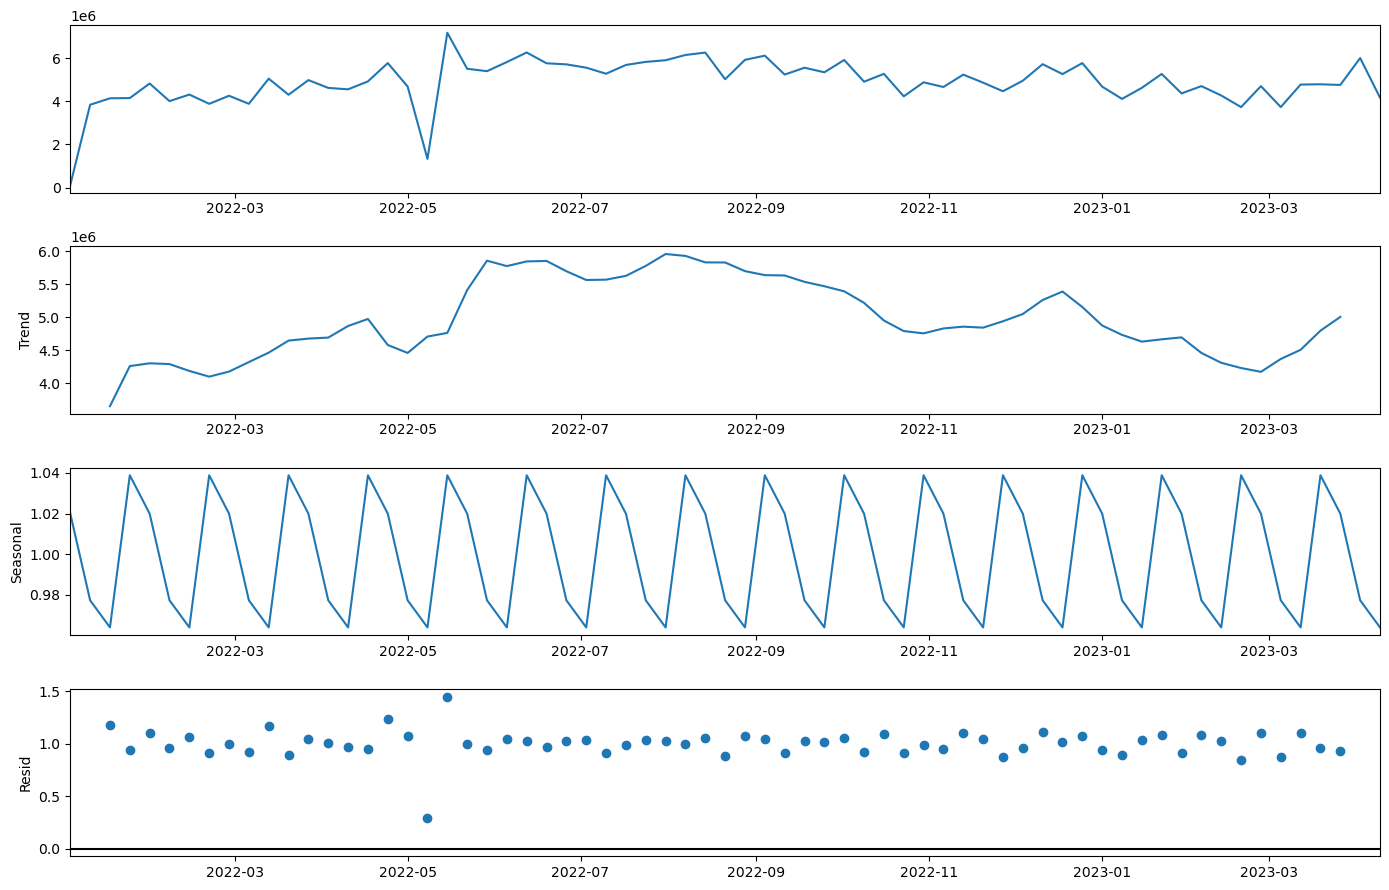

In [18]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_comp,model='multiplicative', period=4) ## seasonal decomposition
ax=res.plot()
plt.show()

From the seasonal decomposition method applied to the time series data, the following observations can be made:
- Trend: there was an overall upward trend in the number of products sold from January until August, followed by a downward trend thereafter.
- Seasonal: there was overal a steep increase of product sold and followed by decrease overtime in product sold every month (4 weeks)
- Resiudal: there were 2 point that are located distinctly from the rest of the data, this indicates that during those periods, there was a parabolic increase and decrease in the number of items sold that could not be explained by the trend and seasonal components alone.

##### -- Stationary Analysis --

In [19]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
## function to check stationary

In [20]:
check_stationarity(df_comp['quantity']) ## applying the function into the dataframe

ADF Statistic: -3.328821
p-value: 0.013638
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
Stationary


It has been proved by the function above that the 'quantity' target is stationary (underlying time series is stationary).

*source: https://www.tutorialspoint.com/why-do-time-series-have-to-be-stationary-before-analysis

##### -- Autocorrelation Analysis --

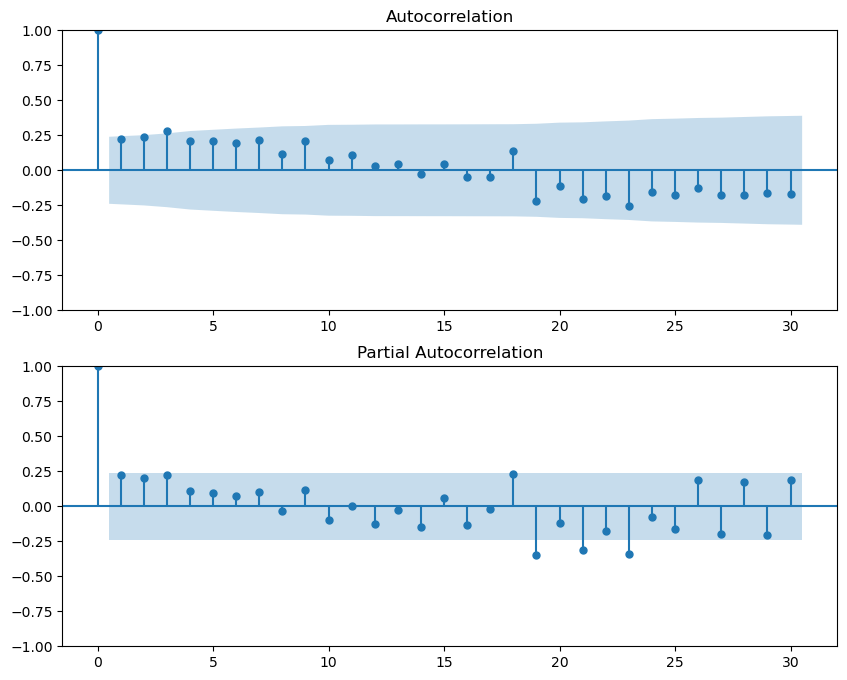

In [21]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

plot_acf(df_comp.quantity, lags=30, ax=ax[0])       ## plotting Autocorrelation or q    
plot_pacf(df_comp.quantity, lags=30, ax=ax[1])      ## plotting Partial-Autocorrelation or p

plt.show()

The blue area in the ACF and PACF plots represents the 95% confidence interval, and any values (lollipops) that fall outside of this range indicate statistically significant autocorrelation at that lag. Therefore, we should pay attention to the lollipops that fall outside or are close to the blue area as those lags will be used as parameters for the model. In ACF the more lollipop falls outside the blue zone also means that the data is not stationary.*

Autocorrelation (q)
- lag 2,3,4

Partial-Autocorrelation (p)
- lag 2, 4, 19, 20, 22, 24, 30

*source: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c#:~:text=The%20difference%20between%20ACF%20and,indicator%20of%20the%20significance%20threshold.

### Modeling

For this journal, we will be working on a univariate time series dataset, which requires forecasting with only a single variable. We will use three popular models for time series forecasting, namely ARIMA (AutoRegressive Integrated Moving Average), SARIMA (Seasonal ARIMA), and Holt-Winters model. And I will try to implement LSTM deep learning model and the FB Prophet model while learning it. ARIMA and SARIMA are commonly used models for non-seasonal and seasonal time series, respectively, while Holt-Winters model is appropriate when there is no stable trend and a seasonal pattern is present in the data.

For the whole model we will use MAPE as main comparison since we see that the quantity total is high and it will be easier to compare using the error percentage from the forecast predicted.

In [22]:
## Calculate the index values for each split
train_length = int(len(df_comp) * 0.8)
val_length = int(len(df_comp) - train_length)

## Split the data into training and testing sets
train_data = df_comp[:train_length]
test_data = df_comp[:val_length]

## Verify the sizes of the splits
print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))

Training set size: 53
Testing set size: 14


##### -- Auto-ARIMA --

In [23]:
model = pm.auto_arima(train_data, 
                      start_p=2,                                                    ## starting p with
                      d=0,                                                          ## stationary
                      start_q=2,                                                    ## starting q with
                      max_p=30,                                                     ## maximum p
                      max_q=4,                                                      ## maximum q
                      seasonal=False,                                               ## no seasonality
                      stepwise=False,
                      approximation=False,
                      trace=True, error_action='ignore', suppress_warnings=True)

print(model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1789.585, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1760.300, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1755.916, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1756.684, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1758.452, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1642.174, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1625.660, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1627.658, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1627.812, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1628.918, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1632.814, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1626.783, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1631.066, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1629.670, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0

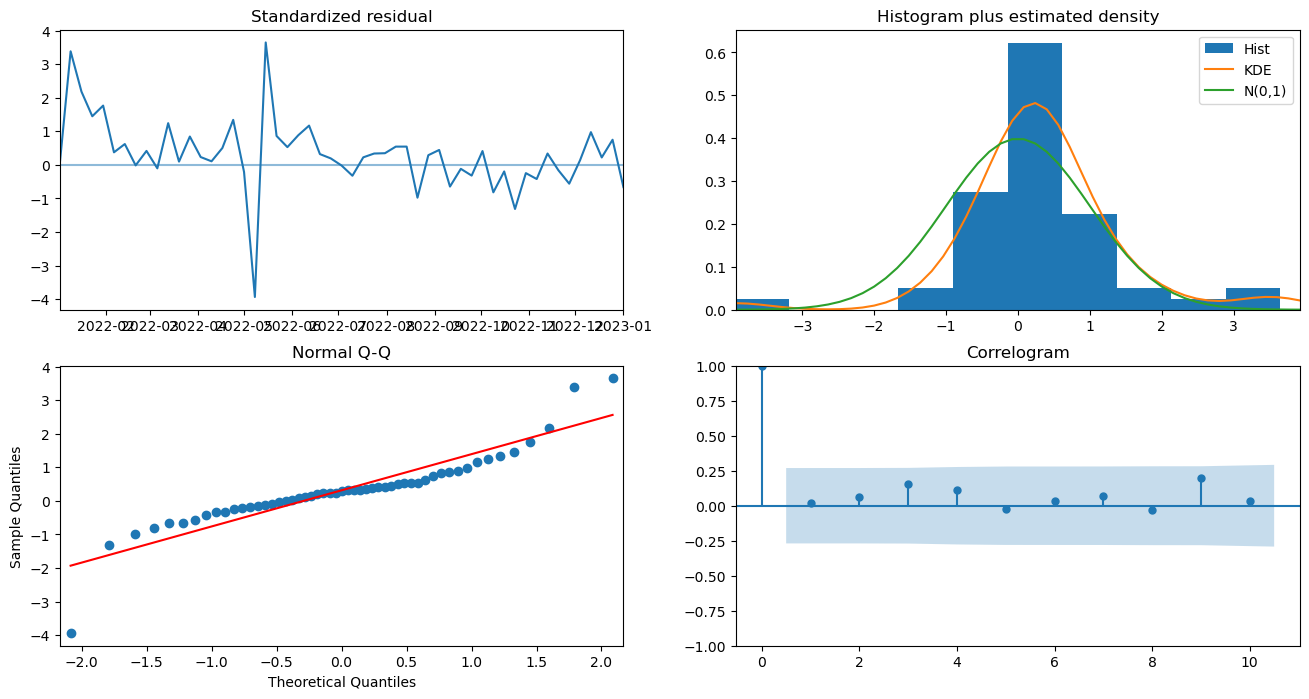

In [24]:
model.plot_diagnostics(figsize=(16,8))  ## visualizatuin plot of using ARIMA(1,0,1)
plt.show()

From the visualization recommended ARIMA (1,0,1) we can conclude that:
- Top left: residual error fluctuate around mean line but there were times when it spike up and down which mean there is some information in the residuals that the model is not capturing.
- Top right: the green line shows the perfect distribution would look like, and the orange line shows the condition of the distribution current residual which shows the distribution is still normal in my point of view
- Bottom left: the quantile-quantile plot shows similiar meaning to the histogram plot, the more plot reside within the red line means normal distribution
- Bottom right: all lollipop within the blue range indicating that there is no autocorrelation among the residuals.

According to the results of the auto-arima model, the suggested best parameters for the model are q (MA order) = 1 and p (AR order) = 1. However, relying solely on one AIC score may not be sufficient, and it's important to evaluate the performance of the model using visualizations. Therefore, we will explore and compare the performance of the ARIMA and SARIMA models further.

##### -- ARIMA Model --

In [25]:
## Define the ARIMA model and fit it to the data
model = ARIMA(train_data, order=(1,0,1))
model_fit = model.fit()

## Predit the test data
prediction = model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True)

## Forecast future values of the time series
forecast = model_fit.forecast(14) 

## Calcuate metrics
score_mae = mean_absolute_error(test_data, forecast)
score_mape = mean_absolute_percentage_error(test_data, forecast)

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))


MAE: 1063101.6075255526
MAPE: 2.9385598416271583


MAPE shows the error percentage is 2.93% from the reccomended ARIMA(1,0,1) which is good enough. Let see from the visualization how the forecast works.

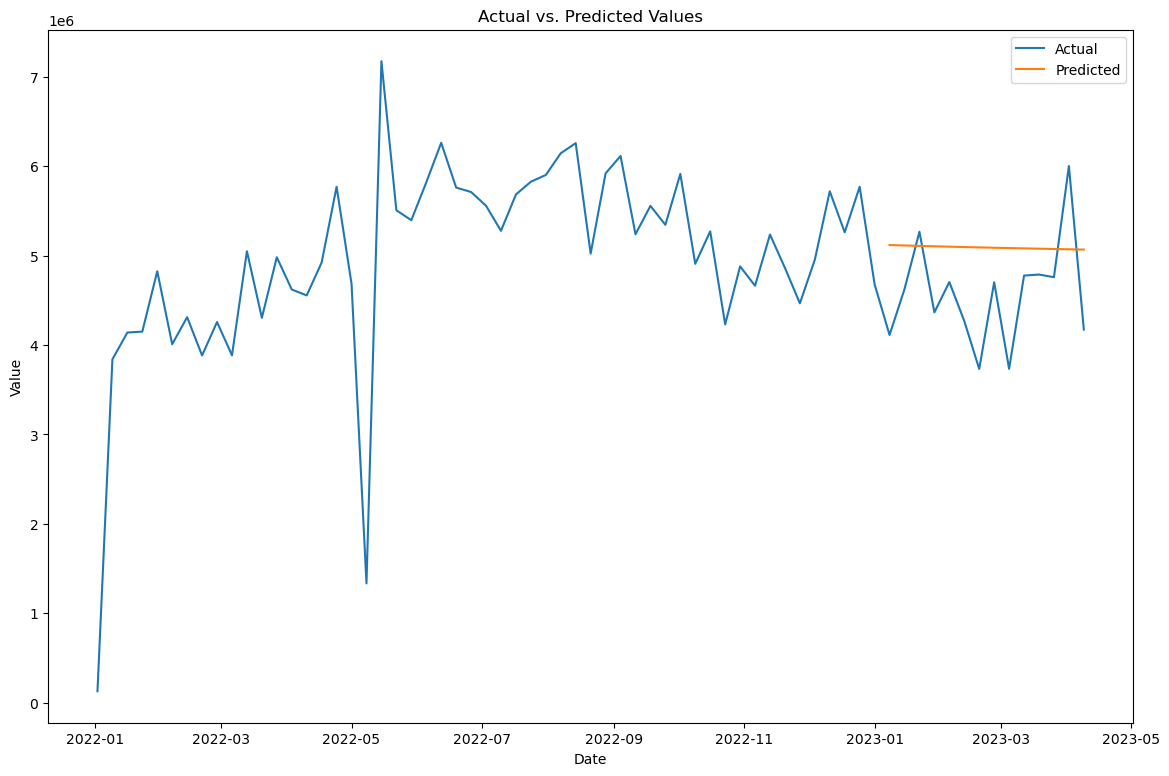

In [26]:
## visualization
plt.plot(df_comp.index, df_comp['quantity'], label='Actual')    ## plot the actual data
plt.plot(forecast.index, forecast, label='Predicted')           ## plot the predicted values
plt.title('Actual vs. Predicted Values')                        ## set the plot title 
plt.xlabel('Date')                                              ## x axis label
plt.ylabel('Value')                                             ## y axis label
plt.legend()                                                    ## show legend
plt.show()

Even though the result error is quite good but the forecast visualization is not good enough to represent the in real life situation because the line predicion is flat. For that reason we will find more suitable parameter for the ARIMA.

In [27]:
## Define the ARIMA model and fit it to the data
model = ARIMA(train_data, order=(24,0,2))
model_fit = model.fit()

## Forecast future values of the time series
forecast = model_fit.forecast(14) 

## Calcuate metrics
score_mae = mean_absolute_error(test_data, forecast)
score_mape = mean_absolute_percentage_error(test_data, forecast)

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))

MAE: 605036.3702946965
MAPE: 2.0678830149964793


With using ARIMA(24,0,2) we get better result in the error percentage from the recommended AUTO-ARIMA and let see if we get better visualization.

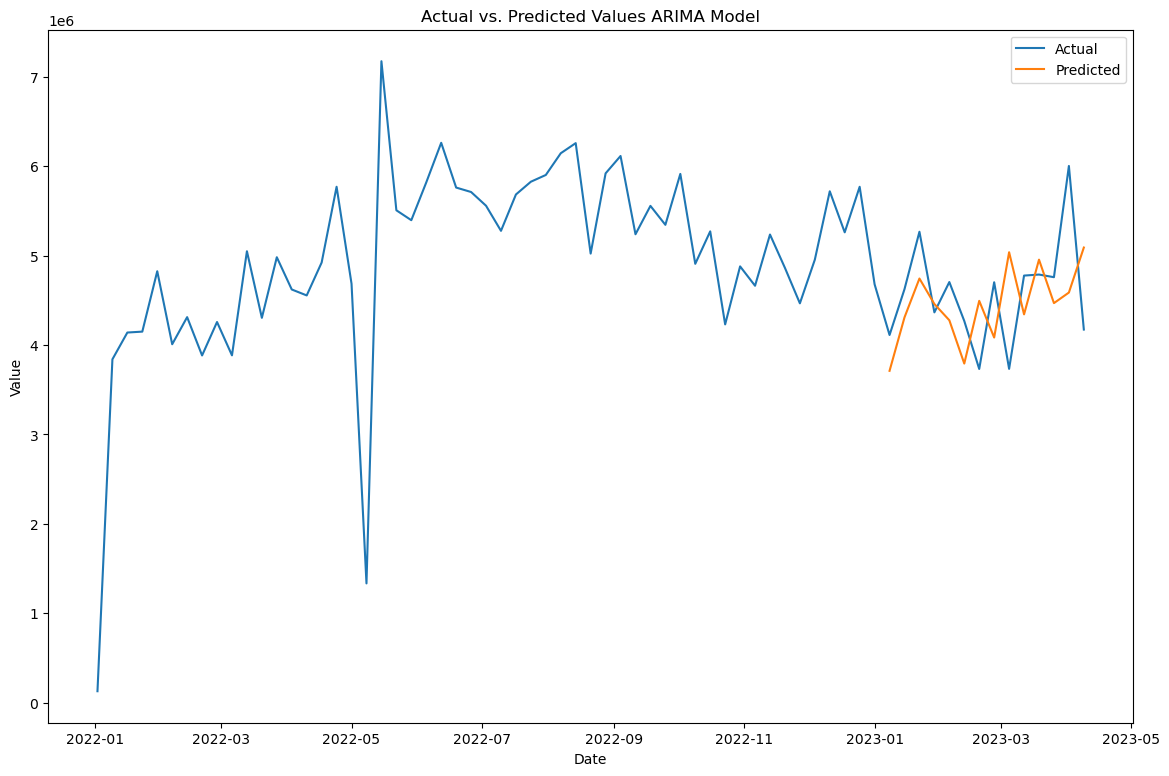

In [28]:
## visualization
plt.plot(df_comp.index, df_comp['quantity'], label='Actual')    ## plot the actual data
plt.plot(forecast.index, forecast, label='Predicted')           ## plot the predicted values
plt.title('Actual vs. Predicted Values ARIMA Model')                        ## set the plot title 
plt.xlabel('Date')                                              ## x axis label
plt.ylabel('Value')                                             ## y axis label
plt.legend()                                                    ## show legend
plt.show()

Based on the visualization, it appears that the ARIMA(24,0,2) model not only has a better error rate but also provides better forecasting results compared to the previous model. 

Now let see if SARIMA model has a better result than ARIMA.

##### -- SARIMA Model --

In [29]:
## Define the SARIMA model and fit it to the data
model = SARIMAX(train_data, order=(3,0,3),seasonal_order=(20,0,3,4))
model_fit = model.fit()

## Forecast future values of the time series
forecast = model_fit.forecast(steps=14) 

## Calcuate metrics
score_mae = mean_absolute_error(test_data, forecast)
score_mape = mean_absolute_percentage_error(test_data, forecast)

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))

MAE: 1162527.7895554195
MAPE: 2.7613756724581626


From SARIMA model we can see that it has no better result than ARIMA with all the possibilites parameter I have tried. In that case let us see the result from the next model.

##### -- Holts-Winter Model --

In [30]:
## Define Holts Winter model and fit it into data
model = ExponentialSmoothing(train_data, seasonal_periods=4, trend='mul', seasonal='mul')
model_fit = model.fit()

## Forecast future values of the time series
forecast = model_fit.forecast(len(test_data)) 

## Calcuate metrics
score_mae = mean_absolute_error(test_data, forecast)
score_mape = mean_absolute_percentage_error(test_data, forecast)

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))


MAE: 841681.5390161874
MAPE: 2.7737756241274485


In the trend and seasonal parameter we use multiplicative as we followed what we found from the EDA. Using Holts-Winter model did not result in a better score than ARIMA and SARIMA.

##### -- LSTM Model --

For using LSTM model there are more steps needs to be done because LSTM is deep learning method which input is in 3 dimensional shape; number of sample, the time steps (sequence length) and the number of feature in each time step, let see the implementation below.

In [31]:
## Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

## Create sequences for input data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

## Set the sequence length
seq_length = 12

## Create sequences for training data
X_train, y_train = create_sequences(train_data, seq_length)

## Create the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## Fit the model
model.fit(X_train, y_train, epochs=100, verbose=1)

## Create sequences for testing data
X_test, y_test = create_sequences(test_data, seq_length)

## Predict future values
predicted = []
for i in range(len(X_test)):
    x_input = X_test[i].reshape((1, seq_length, 1))
    yhat = model.predict(x_input, verbose=0)
    predicted.append(yhat[0][0])

## Scale the predictions back to original values
predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))

## Calculate metrics
score_mae = mean_absolute_error(test_data[seq_length:], predicted)
score_mape = mean_absolute_percentage_error(test_data[seq_length:], predicted)

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))


Epoch 1/100
2/2 [==============================] - 6s 23ms/step - loss: 0.5672
Epoch 2/100
2/2 [==============================] - 0s 15ms/step - loss: 0.3600
Epoch 3/100
2/2 [==============================] - 0s 14ms/step - loss: 0.1848
Epoch 4/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0382
Epoch 5/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0750
Epoch 6/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0771
Epoch 7/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0370
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0321
Epoch 9/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0484
Epoch 10/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0520
Epoch 11/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0346
Epoch 12/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0225
Epoch 13/100
2/2 [==============================]

The most noticable difference when use LSTM in timeseries model is data normalization, sequences for input data and predicted values.
- Data normalization: LSTM model is sensitive to the scale distribution of input data
- Sequences for input data: LSTM model is designed to have a sequential of input, where I said earlier the input of LSTM is in 3D shape, so in this sequences step we want to put the time steps.
- Predicted future values: same like sequences where we want to extract the value of the time steps as the predicted values.

However, we do not need to worry excessively as the results from the LSTM model may not be better from other time series models.

##### -- Prophet Model --

In using prophet model from Facebook we need to change the name of the column into specific name.

In [32]:
df_prophet = df_comp.copy()
df_prophet.head()  ## overview of the dataframe before

,quantity
week_end_date,
2022-01-02,128808
2022-01-09,3839557
2022-01-16,4138934
2022-01-23,4149077
2022-01-30,4824273


In [33]:
df_prophet = df_prophet.reset_index().rename(columns={'week_end_date':'ds', 'quantity':'y'}) ## change index into ds and feature into y
df_prophet.head()                                                                         ## overview of dataframe after

,ds,y
0,2022-01-02,128808
1,2022-01-09,3839557
2,2022-01-16,4138934
3,2022-01-23,4149077
4,2022-01-30,4824273


In [34]:
## new train-test set from new dataframe
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]

## calling Prophet model and fit it into train
model = Prophet()
model.fit(train_df)

## Make predictions
future = model.make_future_dataframe(periods=len(test_df), freq='W')
forecast = model.predict(future)

## Evaluate the model
score_mae = mean_absolute_error(test_df['y'], forecast['yhat'][train_size:train_size+len(test_df)])
score_mape = mean_absolute_percentage_error(test_df['y'], forecast['yhat'][train_size:train_size+len(test_df)])

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))


07:07:15 - cmdstanpy - INFO - Chain [1] start processing
07:07:16 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1412027.568313893
MAPE: 0.3280586120262986


Using Facebook Prophet did not result in a better score than other models. The mean percentage error of 32.8% is worse than the first three models.

### Model Evaluation

From 5 models that we have tried so far:
1. ARIMA MAPE       : 2.07%

2. SARIMA MAPE      : 2.76%

3. Holts-Winter MAPE: 2.77%

4. LSTM MAPE        : 5.98%

5. Prophet          : 32.8%

ARIMA model shows the best minimum error in forecast, for that reason we will use ARIMA model to predict the quantity sold for several weeks ahead from this dataset. With the low MAPE score, ARIMA model has proven that this model can be used on non-linear trend and without seasonal pattern but need to be remember that this model may not suitable for highly volatile or unpredictable time series data like what happened on the month of May.

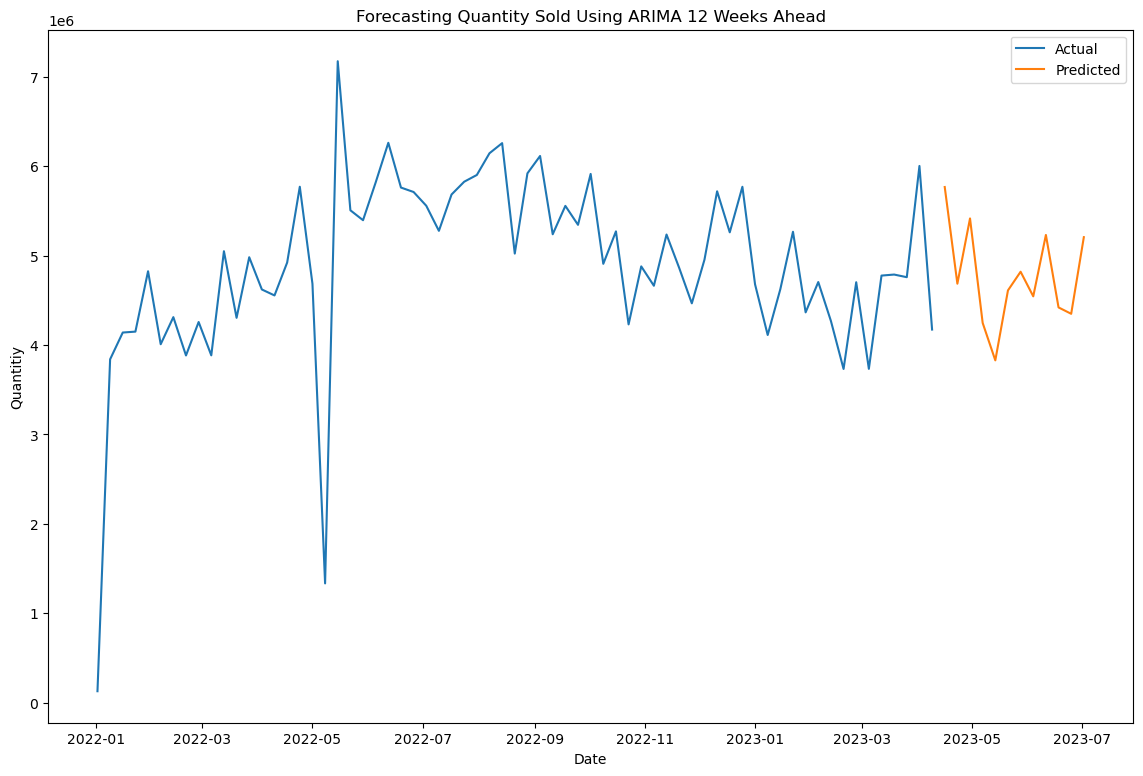

In [35]:
## Calling the ARIMA model
model = ARIMA(df_comp, order=(24,0,2))
model_fit = model.fit()

## Forecast 12 weeks ahead
forecast = model_fit.forecast(12)

## visualization
plt.plot(df_comp.index, df_comp['quantity'], label='Actual')    ## plot the actual data
plt.plot(forecast, label='Predicted')                           ## plot the predicted values
plt.title('Forecasting Quantity Sold Using ARIMA 12 Weeks Ahead')                        ## set the plot title 
plt.xlabel('Date')                                              ## x axis label
plt.ylabel('Quantitiy')                                             ## y axis label
plt.legend()                                                    ## show legend
plt.show()


In [36]:
forecast = pd.DataFrame(forecast).reset_index().rename(columns={'index':'week_end_date','predicted_mean':'quantitiy'})
forecast

,week_end_date,quantitiy
0,2023-04-16,5.765873e+06
1,2023-04-23,4.685135e+06
2,2023-04-30,5.414349e+06
3,2023-05-07,4.246380e+06
4,2023-05-14,3.827795e+06
5,2023-05-21,4.609986e+06
6,2023-05-28,4.818692e+06
7,2023-06-04,4.543558e+06
8,2023-06-11,5.230072e+06
9,2023-06-18,4.419555e+06


Above is the visualization from 12 weeks forecasting of all quantity items sold using ARIMA model which previously proven with 2% margin error. From the graph we can see that 16th April would be a quite increase in forecasting quantitiy items sold followed by steep decrease in early May. Using asumption based on the Indonesian calender it might be due to people are getting back to work after a long Ramadhan holiday.

All the steps we have done above is forecasting based on all the products combined. In real life it would be better to implement it on specific item or category

### Business Implementation

I am interested to see how the specific item (the one sold the most on EDA) perform with the model forecasting. And we take this one as the business implementation in real life.

In [37]:
most_item_sold = df[(df['product_item']=='2949ca4cfbf13969bccfbb9817f2526a')].groupby('week_end_date')['quantity'].sum() ## making a dataframe for most item sold

In [38]:
check_stationarity(most_item_sold) ## check if the dataframe is stationary

ADF Statistic: -5.027513
p-value: 0.000020
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Stationary


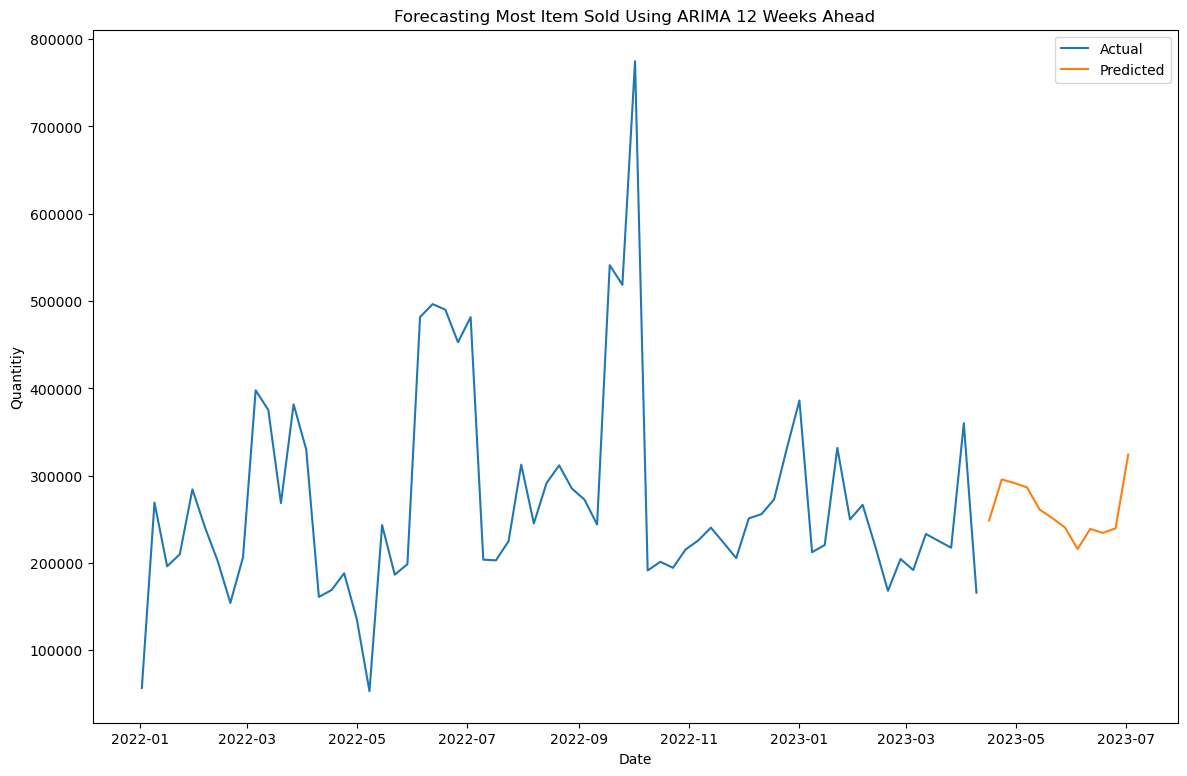

In [39]:
## Calling the ARIMA model
model = ARIMA(most_item_sold, order=(24,0,2))
model_fit = model.fit()

## Forecast 12 weeks ahead
forecast = model_fit.forecast(12)

## visualization
plt.plot(most_item_sold.index, most_item_sold.values, label='Actual')   ## plot the actual data
plt.plot(forecast, label='Predicted')                                   ## plot the predicted values
plt.title('Forecasting Most Item Sold Using ARIMA 12 Weeks Ahead')      ## set the plot title 
plt.xlabel('Date')                                                      ## x axis label
plt.ylabel('Quantitiy')                                                 ## y axis label
plt.legend()                                                            ## show legend
plt.show()

The visualization indicates that there will be an increase in item sales over the next two weeks and in the month of July. As a data scientist, we can recommend the following actions based on this insight:
- For the warehouse, they can prepare their inventory items and manage them accordingly to ensure that there are enough stocks available to meet the expected demand.
- For the company, we can suggest implementing a promotional strategy such as offering bundle discounts during the anticipated high sales month. This would help to clear out old inventory while keeping the number of items sold high and maintaining the same profit margin.
- For the seller partners, we can advise them to focus their marketing efforts on specific items or categories during the predicted high sales month

# Overall Analysis

- The dataset contains information on the number of items sold by a company from the beginning of 2022 until April 2023, spanning 67 weeks.
- The dataset contains a total of 2037 unique items, with the most sold item being identified by the product ID '2949ca4cfbf13969bccfbb9817f2526a'. The number of items sold of this product is so high that the second most item sold is only half of it.
- Interestingly, the highest and lowest points of items sold occurred during the same month, which is in May 2022, and it is assumed to be due to a long holiday that occurred during that time.
- From the beginning of 2022 until August, there was an upward trend in items sold followed by a downward trend thereafter.
- A recurring pattern observed in the data is the consistent increase in items sold followed by a decrease, which happens every month.
- Out of the several models tested on the dataset, the best performing model is ARIMA, with an average error of 2% in the forecast. Therefore, the model is deemed suitable for deployment as long as the data is assumed stationary.
- Possible improvements to the model include:
    - Utilizing the BIC (Bayesian information criterion) technique to determine the parameters that could potentially lead to a better model.
    - Trying ensemble learning techniques to combine different models and potentially achieve better accuracy.
    -   that include more than one parameter to get stronger exogenous variables.